<a href="https://colab.research.google.com/github/riskingsun/analytics/blob/master/FirstFineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<Axes: >

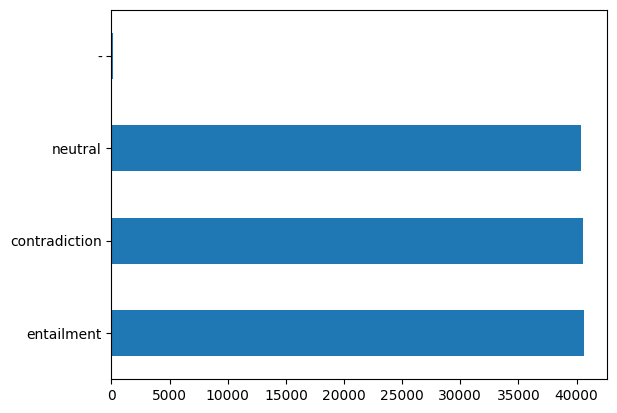

In [5]:
# https://www.kdnuggets.com/fine-tuning-llamav2-with-qlora-on-google-colab-for-free
import pandas as pd


#df = pd.read_csv('snli_1.0_train_matched.csv', sep='\t')
df = pd.read_csv('./sp-data/firstfinetuning/snli_1.0_train.txt', sep='\t')
df['gold_label'].value_counts().plot(kind='barh')

In [6]:
df[df['gold_label'] == 'contradiction'].sample(10)[['sentence1', 'sentence2']]

,sentence1,sentence2
11391,A woman in a red and white dress standing next...,A man and woman are sitting on a blanket at a ...
108887,A woman holding an umbrella and a cup and hand...,The woman is running with her child from the s...
102277,A dog tugs on a piece of fabric.,A cat plays with a dead mouse.
96784,A man in uniform waves and smiles at camera,A man is frowning
45297,A young boy in a gray shirt holds onto two ove...,The boy is wearing pink
31389,A person rock climbing and another man on the ...,Two people are scuba diving.
22419,Two men and one woman are sitting in a subway ...,People sit on a trolley.
116440,"A man with tattoos on his arm, wearing a yello...",The man sits on the ground.
2538,Two men wearing bright green shirts are lookin...,Two women are looking for something.
73381,A man speaking on a cellphone while smoking ou...,Sandy was texting Judy.


In [8]:
def convert_to_format(row):
    sentence1 = row['sentence1']
    sentence2 = row['sentence2']
    prompt = """Below is an instruction that describes a task paired with input that provides further context. Write a response that appropriately completes the request."""
    instruction = """Given the following sentence, your job is to generate the negation for it in the json format"""
    input = str(sentence1)
    response = f"""```json
{{'orignal_sentence': '{sentence1}', 'generated_negation': '{sentence2}'}}
```
"""
    if len(input.strip()) == 0:  #  prompt + 2 new lines + ###instruction + new line + input + new line + ###response
        text = prompt + "\n\n### Instruction:\n" + instruction + "\n### Response:\n" + response
    else:
        text = prompt + "\n\n### Instruction:\n" + instruction + "\n### Input:\n" + input + "\n" + "\n### Response:\n" + response

    # we need 4 columns for auto train, instruction, input, output, text
    return pd.Series([instruction, input, response, text])

new_df = df[df['gold_label'] == 'contradiction'][['sentence1', 'sentence2']].apply(convert_to_format, axis=1)
new_df.columns = ['instruction', 'input', 'output', 'text']

new_df.to_csv('snli_instruct.csv', index=False)